# Group Equivariant Neural Networks Experiment

### Deep learning and Applied AI exam project.

In this notebook I'm going to test the performance of **Group Equivariant Neural Networks**. I will do a series of tests in two standard datasets :

- Fashion-MNIST
- CIFAR-10

There would be a comparison with standard Convolutioanl Networksl

### 1) Set the environment

We need to download some new libraries.

In [1]:
! pip install numpy scipy matplotlib nose

     |████████████████████████████████| 154 kB 5.3 MB/s 


In [2]:
pip install chainer

     |████████████████████████████████| 1.0 MB 5.3 MB/s 
  Created wheel for chainer: filename=chainer-7.8.0-py3-none-any.whl size=967734 sha256=65a5b6b3570473ccfa97fa0ad78b2c6d364953adc4a99da37f7b91297e26d644
  Stored in directory: /root/.cache/pip/wheels/8d/45/4c/c961846626d4db2511e4acbd5056eefb2aeedcec8208a3ca42
Successfully built chainer


In [3]:
! git clone https://github.com/adambielski/GrouPy.git

Cloning into 'GrouPy'...
remote: Enumerating objects: 167, done.
remote: Total 167 (delta 0), reused 0 (delta 0), pack-reused 167
Receiving objects: 100% (167/167), 141.99 KiB | 1.92 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [4]:
%cd /content/GrouPy

! ls

/content/GrouPy
groupy	 p4_anim.gif   p4m_fmaps.png  requirements.txt
LICENSE  p4_fmaps.png  README.md      setup.py


In [5]:
! python3 "/content/GrouPy/setup.py" install

running install
running build
running build_py
creating build
creating build/lib
creating build/lib/groupy
copying groupy/__init__.py -> build/lib/groupy
creating build/lib/groupy/garray
copying groupy/garray/D4_array.py -> build/lib/groupy/garray
copying groupy/garray/test_garray.py -> build/lib/groupy/garray
copying groupy/garray/finitegroup.py -> build/lib/groupy/garray
copying groupy/garray/p4m_array.py -> build/lib/groupy/garray
copying groupy/garray/p4_array.py -> build/lib/groupy/garray
copying groupy/garray/__init__.py -> build/lib/groupy/garray
copying groupy/garray/Z2_array.py -> build/lib/groupy/garray
copying groupy/garray/garray.py -> build/lib/groupy/garray
copying groupy/garray/C4_array.py -> build/lib/groupy/garray
copying groupy/garray/matrix_garray.py -> build/lib/groupy/garray
creating build/lib/groupy/gconv
copying groupy/gconv/make_gconv_indices.py -> build/lib/groupy/gconv
copying groupy/gconv/__init__.py -> build/lib/groupy/gconv
creating build/lib/groupy/gconv/c

### 2) Import the libraries

In [6]:
import torch
import numpy as np
import sklearn
import scipy
import pandas as pd
import torch
import matplotlib.pyplot as plt

import torchvision
from typing import *
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torch.nn import functional as F
from torch.nn import Conv2d
from torch.nn import MaxPool2d as MaxPool2d
from torchvision import datasets, models, transforms

import os

#import the library dedicated to Groups
from groupy.gconv.pytorch_gconv.pooling import plane_group_spatial_max_pooling
from groupy.gconv.pytorch_gconv import P4ConvZ2, P4ConvP4

Turn on the GPU.

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda:0


setting the seed.

In [8]:
import random
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

torch.cuda.manual_seed(0)

### 3) Load the dataset.

In [9]:
# basic transformation
image_transforms = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomRotation(degrees=100),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,)),
    ]
)


# build the dataloader for trainingset
train_loader = torch.utils.data.DataLoader( datasets.CIFAR10("../prova/data", train=True, 
                            download=True, transform=image_transforms
                            ),
                            batch_size=64,
                            shuffle=True,
                            )


# build the dataloader for testset
test_loader = torch.utils.data.DataLoader( datasets.CIFAR10("../prova/data", train=False,
                            download=True, transform=image_transforms
                            ),
                            batch_size=1000,
                            shuffle=True,
                            )



# build the dataloader for trainingset
train_loader2 = torch.utils.data.DataLoader( datasets.FashionMNIST("../prova/data", train=True, 
                            download=True, transform=image_transforms
                            ),
                            batch_size=64,
                            shuffle=True,
                            )



# build the dataloader for trainingset
test_loader2 = torch.utils.data.DataLoader( datasets.FashionMNIST("../prova/data", train=False, 
                            download=True, transform=image_transforms
                            ),
                            batch_size=1000,
                            shuffle=True,
                            )

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../prova/data/cifar-10-python.tar.gz to ../prova/data
Files already downloaded and verified


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../prova/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../prova/data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../prova/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../prova/data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../prova/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../prova/data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../prova/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../prova/data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [10]:
# Retrieve the image size and the number of color channels for both the dataset
x, _ = next(iter(train_loader))

batch_size = x.shape[0]
n_channels = x.shape[1]
input_size_w = x.shape[2]
input_size_h = x.shape[3]
input_size = input_size_w * input_size_h


dataiter = iter(train_loader)
dataiter2 = iter(train_loader2)
images, labels = dataiter.next()
images2,labels2 = dataiter2.next()

print(images.shape)
print(labels.shape)
print(len(train_loader))

print(images2.shape)
print(labels.shape)
print(len(train_loader))

torch.Size([64, 1, 32, 32])
torch.Size([64])
782
torch.Size([64, 1, 28, 28])
torch.Size([64])
782


### 4) Models

#### Models for CIFAR-10

In [11]:
class GroupCNN(nn.Module):
    
    
    def __init__(self):
        super(GroupCNN, self).__init__()
        self.conv1 = P4ConvZ2(1, 128, kernel_size=3)
        self.conv2 = P4ConvP4(128, 256, kernel_size=3)
        self.conv3 = P4ConvP4(256, 64, kernel_size=3)
        self.conv4 = P4ConvP4(64, 32, kernel_size=3)
        self.fc1 = nn.Linear(3200, 32)
        self.fc2 = nn.Linear(32, 10)


    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = plane_group_spatial_max_pooling(x, 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = plane_group_spatial_max_pooling(x, 2)
        
        # now flatten and MLP
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.fc2(x)
        return F.log_softmax(x)
    
    
    
class CNN(nn.Module):
    
    
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = Conv2d(1, 256, kernel_size=3, stride=1, padding=0)
        self.conv2 = Conv2d(256, 512, kernel_size=3, stride=1, padding=0)
        self.conv3 = Conv2d(512, 128, kernel_size=3, stride=1, padding=0)
        self.conv4 = Conv2d(128, 64, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(1600, 32)
        self.fc2 = nn.Linear(32, 10)


    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = MaxPool2d(2)(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = MaxPool2d(2)(x)
        
        # now flatten and MLP
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.fc2(x)
        return F.log_softmax(x)
    

#### Models for Fashion-MNIST

In [12]:
class GroupCNN_2(nn.Module):
    
    
    def __init__(self):
        super(GroupCNN_2, self).__init__()
        self.conv1 = P4ConvZ2(1, 128, kernel_size=3)
        self.conv2 = P4ConvP4(128, 256, kernel_size=3)
        self.conv3 = P4ConvP4(256, 64, kernel_size=3)
        self.conv4 = P4ConvP4(64, 32, kernel_size=3)
        self.fc1 = nn.Linear(2048, 32)
        self.fc2 = nn.Linear(32, 10)


    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = plane_group_spatial_max_pooling(x, 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = plane_group_spatial_max_pooling(x, 2)
        
        # now flatten and MLP
        x = x.view(x.size()[0], -1)
        #print(x.size())
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.fc2(x)
        return F.log_softmax(x)
    
    
    
class CNN_2(nn.Module):
    
    
    def __init__(self):
        super(CNN_2, self).__init__()
        self.conv1 = Conv2d(1, 256, kernel_size=3, stride=1, padding=0)
        self.conv2 = Conv2d(256, 512, kernel_size=3, stride=1, padding=0)
        self.conv3 = Conv2d(512, 128, kernel_size=3, stride=1, padding=0)
        self.conv4 = Conv2d(128, 64, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(1024, 32)
        self.fc2 = nn.Linear(32, 10)


    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = MaxPool2d(2)(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = MaxPool2d(2)(x)
        
        # now flatten and MLP
        x = x.view(x.size()[0], -1)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.fc2(x)
        return F.log_softmax(x)

### 5) Trainig Functions

In [13]:
log_freq = len(train_loader)//batch_size * 8

# SOME UTILITY FUNCTION IN ORDER TO MAKE MORE ORGANIZED THE CODE
def train(epoch, loader , net, optimizer, loss_func, log_freq=log_freq):
    
    running_loss = 0.0
    correct = 0
    total = 0
    losses = []
    
    for i, data in enumerate(loader, start=1):
        
        # get the inputs and load into GPU if available
        x, labels = data
        x, labels = x.to(device), labels.to(device)


        # zero the parameter gradients
        optimizer.zero_grad()
        

        # forward + backward + optimize
        outputs = net(x)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        #get predications
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        

        # print statistics every log_freq mini batch
        running_loss += loss.item()
        if (i) % log_freq == 0:    # print every log_freq mini batches
            print('[Epoch : %d, Iter: %5d] loss: %.3f' %
                  (epoch + 1, i, running_loss / log_freq))
            losses.append( running_loss / log_freq)
            running_loss = 0.0
            print('Top1 Accuracy of the network on the trainset images:', correct / total)
            correct=0
            total=0   
            
    return losses


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



def test(net, loader, train_data=False):
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        
        net.eval()
        
        for batch_idx, data in enumerate(loader):
            
            if batch_idx == len(loader):
                break
            
            #load into GPU if available
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # predict
            output = net(inputs)
            _, predicted = torch.max(output, 1)
            c = (predicted == labels).squeeze().sum().item()
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        
        print('Accuracy of the network on the testset images:', correct / total)

### G-CNN on CIFAR-10

In [ ]:
epochs = 30
learning_rate = 0.001
loss_func = nn.CrossEntropyLoss()



#construct the models + optimizer
model1 = GroupCNN()
print(model1)
print("number of parameters : ", count_parameters(model1))


if torch.cuda.is_available():
    model1.cuda()

optimizer = optim.Adam(model1.parameters(), lr=learning_rate)
loss_value = []


GroupCNN(
  (conv1): P4ConvZ2()
  (conv2): P4ConvP4()
  (conv3): P4ConvP4()
  (conv4): P4ConvP4()
  (fc1): Linear(in_features=3200, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)
number of parameters :  1947594


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[Epoch : 1, Iter:    96] loss: 2.275
Top1 Accuracy of the network on the trainset images: 0.14583333333333334
[Epoch : 1, Iter:   192] loss: 2.192
Top1 Accuracy of the network on the trainset images: 0.19580078125
[Epoch : 1, Iter:   288] loss: 2.106
Top1 Accuracy of the network on the trainset images: 0.21744791666666666
[Epoch : 1, Iter:   384] loss: 2.055
Top1 Accuracy of the network on the trainset images: 0.25146484375
[Epoch : 1, Iter:   480] loss: 1.992
Top1 Accuracy of the network on the trainset images: 0.2805989583333333
[Epoch : 1, Iter:   576] loss: 1.966
Top1 Accuracy of the network on the trainset images: 0.2843424479166667
[Epoch : 1, Iter:   672] loss: 1.919
Top1 Accuracy of the network on the trainset images: 0.3048502604166667
[Epoch : 1, Iter:   768] loss: 1.857
Top1 Accuracy of the network on the trainset images: 0.3263346354166667
[Epoch : 2, Iter:    96] loss: 1.805
Top1 Accuracy of the network on the trainset images: 0.3416341145833333
[Epoch : 2, Iter:   192] lo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the testset images: 0.6418


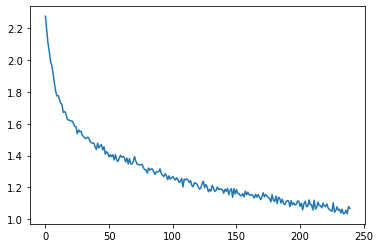

In [ ]:
# training
model1.train()

for i in range(epochs):
    loss_avg = train(epoch=i, loader=train_loader, net=model1, optimizer=optimizer, loss_func=loss_func)
    loss_value.append(loss_avg)


    
y_ax = np.reshape(loss_value, (-1))
x = range(len(y_ax))
    

plt.plot(x,  y_ax)

#testing
test(model1, test_loader)

torch.save(model1.state_dict(), "../prova/model1.pt" )

### CNN on CIFAR-10

In [ ]:
epochs = 30
learning_rate = 0.001
loss_func2 = nn.CrossEntropyLoss()

#same paramters of previous model

#construct the models + optimizer
model2 = CNN()
print(model2)
print("number of parameters : ", count_parameters(model2))


if torch.cuda.is_available():
    model2.cuda()

optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)
loss_value = []


CNN(
  (conv1): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)
number of parameters :  1898026


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[Epoch : 1, Iter:    96] loss: 1.639
Top1 Accuracy of the network on the trainset images: 0.4091796875
[Epoch : 1, Iter:   192] loss: 1.636
Top1 Accuracy of the network on the trainset images: 0.4142252604166667
[Epoch : 1, Iter:   288] loss: 1.637
Top1 Accuracy of the network on the trainset images: 0.4138997395833333
[Epoch : 1, Iter:   384] loss: 1.607
Top1 Accuracy of the network on the trainset images: 0.42333984375
[Epoch : 1, Iter:   480] loss: 1.619
Top1 Accuracy of the network on the trainset images: 0.4186197916666667
[Epoch : 1, Iter:   576] loss: 1.594
Top1 Accuracy of the network on the trainset images: 0.41748046875
[Epoch : 1, Iter:   672] loss: 1.634
Top1 Accuracy of the network on the trainset images: 0.4124348958333333
[Epoch : 1, Iter:   768] loss: 1.601
Top1 Accuracy of the network on the trainset images: 0.4195963541666667
[Epoch : 2, Iter:    96] loss: 1.574
Top1 Accuracy of the network on the trainset images: 0.4427083333333333
[Epoch : 2, Iter:   192] loss: 1.58

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the testset images: 0.5737


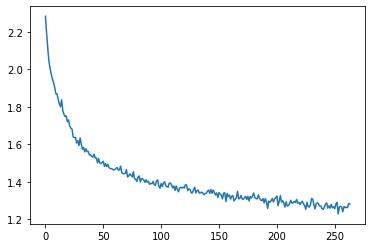

In [ ]:
# training
model2.train()

for i in range(epochs):
    loss_avg = train(epoch=i, loader=train_loader, net=model2, optimizer=optimizer2, loss_func=loss_func2)
    loss_value.append(loss_avg)


    
y_ax = np.reshape(loss_value, (-1))
x = range(len(y_ax))

plt.plot(x,  y_ax)

#testing
test(model2, test_loader)

torch.save(model1.state_dict(), "../prova/model2.pt" )

### G-CNN on Fashion-MNIST

In [ ]:
epochs = 30
learning_rate = 0.001
loss_func3 = nn.CrossEntropyLoss()



#construct the models + optimizer
model_mnist = GroupCNN_2()
print(model_mnist)
print("number of parameters : ", count_parameters(model_mnist))


if torch.cuda.is_available():
    model_mnist.cuda()

optimizer3 = optim.Adam(model_mnist.parameters(), lr=learning_rate)
loss_value = []

GroupCNN_2(
  (conv1): P4ConvZ2()
  (conv2): P4ConvP4()
  (conv3): P4ConvP4()
  (conv4): P4ConvP4()
  (fc1): Linear(in_features=2048, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)
number of parameters :  1910730


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[Epoch : 1, Iter:    96] loss: 1.844
Top1 Accuracy of the network on the trainset images: 0.32861328125
[Epoch : 1, Iter:   192] loss: 1.244
Top1 Accuracy of the network on the trainset images: 0.54443359375
[Epoch : 1, Iter:   288] loss: 1.089
Top1 Accuracy of the network on the trainset images: 0.5979817708333334
[Epoch : 1, Iter:   384] loss: 0.990
Top1 Accuracy of the network on the trainset images: 0.6432291666666666
[Epoch : 1, Iter:   480] loss: 0.930
Top1 Accuracy of the network on the trainset images: 0.66552734375
[Epoch : 1, Iter:   576] loss: 0.914
Top1 Accuracy of the network on the trainset images: 0.6583658854166666
[Epoch : 1, Iter:   672] loss: 0.888
Top1 Accuracy of the network on the trainset images: 0.68408203125
[Epoch : 1, Iter:   768] loss: 0.849
Top1 Accuracy of the network on the trainset images: 0.68408203125
[Epoch : 1, Iter:   864] loss: 0.848
Top1 Accuracy of the network on the trainset images: 0.6884765625
[Epoch : 2, Iter:    96] loss: 0.804
Top1 Accuracy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the testset images: 0.8791


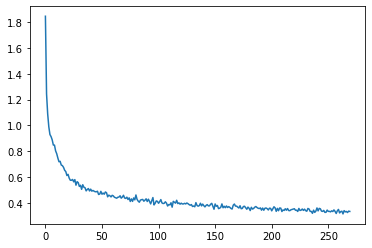

In [ ]:
# training
model_mnist.train()

for i in range(epochs):
    loss_avg = train(epoch=i, loader=train_loader2, net=model_mnist, optimizer=optimizer3, loss_func=loss_func3)
    loss_value.append(loss_avg)


    
y_ax = np.reshape(loss_value, (-1))
x = range(len(y_ax))
    

plt.plot(x,  y_ax)

#testing
test(model_mnist, test_loader2)

torch.save(model_mnist.state_dict(), "../prova/model_mnist.pt" )

### CNN on Fashion-MNIST

In [14]:
epochs = 30
learning_rate = 0.001
loss_func4 = nn.CrossEntropyLoss()



#construct the models + optimizer
model_mnist2 = CNN_2()
print(model_mnist2)
print("number of parameters : ", count_parameters(model_mnist2))


if torch.cuda.is_available():
    model_mnist2.cuda()

optimizer4 = optim.Adam(model_mnist2.parameters(), lr=learning_rate)
loss_value = []

CNN_2(
  (conv1): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)
number of parameters :  1879594


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[Epoch : 1, Iter:    96] loss: 1.759
Top1 Accuracy of the network on the trainset images: 0.3660481770833333
[Epoch : 1, Iter:   192] loss: 1.293
Top1 Accuracy of the network on the trainset images: 0.5263671875
[Epoch : 1, Iter:   288] loss: 1.120
Top1 Accuracy of the network on the trainset images: 0.5875651041666666
[Epoch : 1, Iter:   384] loss: 1.019
Top1 Accuracy of the network on the trainset images: 0.6214192708333334
[Epoch : 1, Iter:   480] loss: 0.946
Top1 Accuracy of the network on the trainset images: 0.6453450520833334
[Epoch : 1, Iter:   576] loss: 0.907
Top1 Accuracy of the network on the trainset images: 0.65625
[Epoch : 1, Iter:   672] loss: 0.876
Top1 Accuracy of the network on the trainset images: 0.6702473958333334
[Epoch : 1, Iter:   768] loss: 0.839
Top1 Accuracy of the network on the trainset images: 0.6962890625
[Epoch : 1, Iter:   864] loss: 0.808
Top1 Accuracy of the network on the trainset images: 0.7023111979166666
[Epoch : 2, Iter:    96] loss: 0.800
Top1 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the testset images: 0.8667


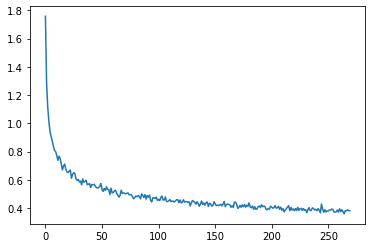

In [15]:
# training
model_mnist2.train()

for i in range(epochs):
    loss_avg = train(epoch=i, loader=train_loader2, net=model_mnist2, optimizer=optimizer4, loss_func=loss_func4)
    loss_value.append(loss_avg)


    
y_ax = np.reshape(loss_value, (-1))
x = range(len(y_ax))
    

plt.plot(x,  y_ax)

#testing
test(model_mnist2, test_loader2)

torch.save(model_mnist2.state_dict(), "../prova/model_mnist2.pt" )